# Импорт библиотек и загрузка датасета

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;

%config InlineBackend.figure_format = 'retina'

In [2]:
# датасет вязт с https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones
ds = pd.read_csv('activity_train.csv') # Загружаем датасет
print('Размерность датасета: {}'.format(ds.shape))

Размерность датасета: (7352, 563)


In [3]:
ds.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [4]:
ds['Activity'].value_counts() # целевая переменная имеет 6 разных значений

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [76]:
x, y = ds.drop(['Activity', 'subject'], axis=1), ds['Activity'] # разделим датасет на X и y(целевой признак)
print('Размерность x: {}, размерность y: {}'.format(x.shape, y.shape))

Размерность x: (7352, 561), размерность y: (7352,)


In [77]:
print('Минимальное значение признака в датасете: {}, \
максимальное значение признака в датасете: {} '.format(x.min().min(), x.max().max()))

Минимальное значение признака в датасете: -1.0, максимальное значение признака в датасете: 1.0 


# K-Means

In [78]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, confusion_matrix
import umap
from sklearn.manifold import TSNE

Алгоритм K-Means требует прямого указания кол-ва кластеров, на которые должен быть разбит датасет. В большинстве прикладных задач кол-во кластеров неизвестно заранее, поэтому позже будет показано как определять оптимальное кол-во кластером с помощью K-means, но пока воспользуемся наишим знаниями о данных - мы знаем, что анализируется 6 видов активности, поэтому установим кол-во кластеров равным <b>6:

In [79]:
%%time
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(x) # определяем принадлежность каждого образца к определенному кластеру

CPU times: user 9.69 s, sys: 2.76 s, total: 12.5 s
Wall time: 1.19 s


В случае большого датасета рекомендуется использовать MiniBatchKMeans. Это пакетная реализация алгоритма, которая загружает данные в память последовательно небольшими пакетами, тем самым снижает используемую память и ускоряет процесс кластеризации

In [95]:
%%time
kmeans = MiniBatchKMeans(n_clusters=6)
clusters = kmeans.fit_predict(x) # определяем принадлежность каждого образца к определенному кластеру
centers = kmeans.cluster_centers_ # центры кластеров

CPU times: user 393 ms, sys: 371 ms, total: 764 ms
Wall time: 103 ms


In [96]:
clusters # метка о принадлежности к кластеру для каждого образца

array([3, 3, 3, ..., 2, 2, 2], dtype=int32)

Визуализируем данные, понижая размернсть с помощью t-SNE, и покрасим маркеры в цвета, в соответствие с кластерами, которые были им присвоены алгоритмом k-means:

In [114]:
tsne = TSNE(n_components=2, metric='euclidean')
x_tsne =  tsne.fit_transform(np.concatenate([x, centers])) # добавим центры кластеров к образцам для визуализации

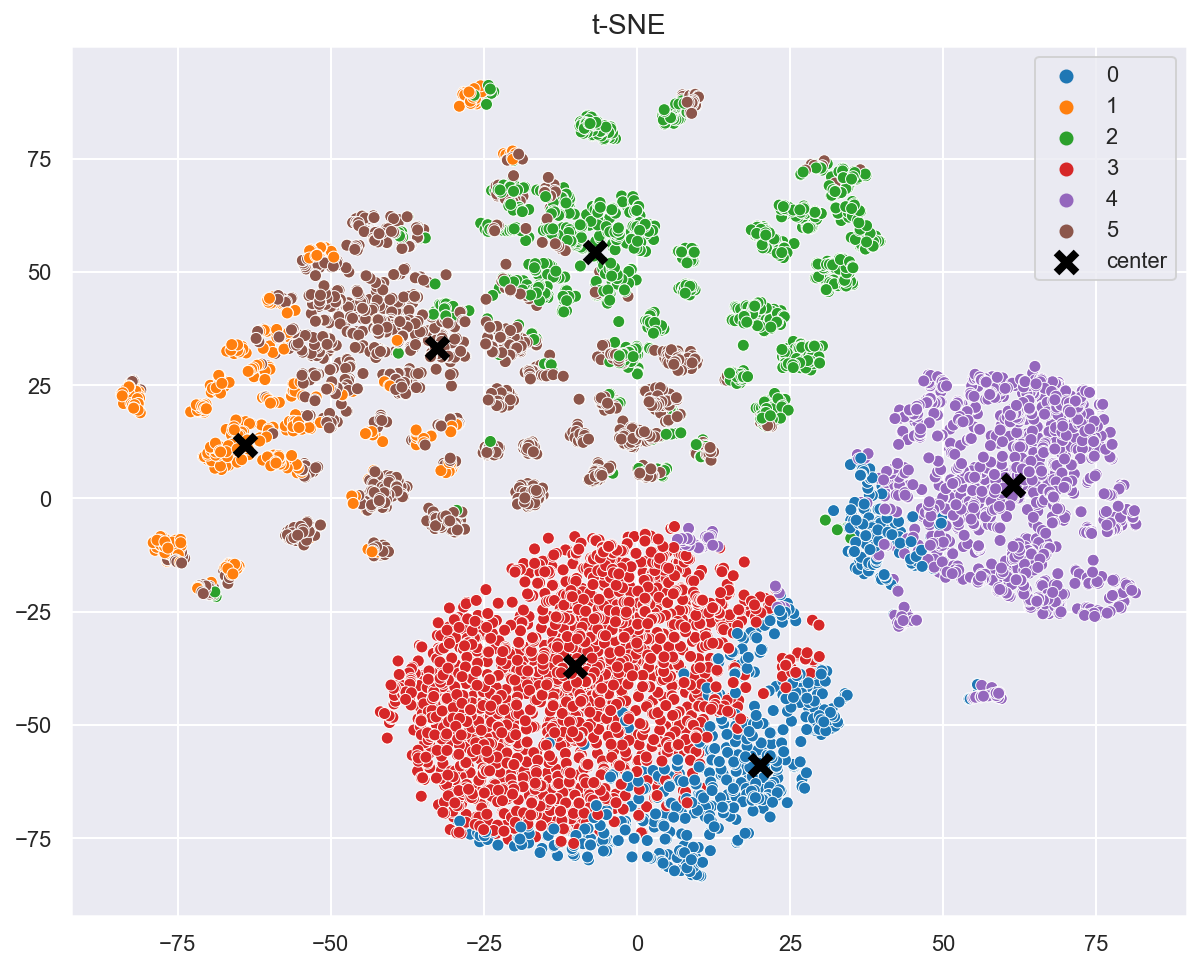

In [115]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=x_tsne[:-6,0], y=x_tsne[:-6,1], hue=clusters, palette='tab10') # визуализируем кластеры
plt.scatter(x=x_tsne[-6:,0], y=x_tsne[-6:,1], marker='x', s=100, c='black', linewidths=4, label='center') # визуализируем центры кластеров
plt.title('t-SNE', fontsize=14)
plt.legend(loc=0);

В данном случае нам известны истиные метки каждого из образцов и мы можем оценить качество работы алгоритма сравнив предсказанные и реальные классы образцов. Однако, предсказанные классы, могут быть перемешаны и, следовательно, не соответствовать реальным обозначениям. Для устранения данной проблемы выполним следующие преобразования:

In [164]:
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder() # кодировщик для перевода целевой переменной из категориальной в численную
y_int = le.fit_transform(y)
labels = np.zeros_like(clusters) # создаем пустой массив
for i in range(6):
    mask = (clusters == i) # маска для элементов, соответствующих данному кластеру
    labels[mask] = mode(y_int[mask])[0] # заполняем массив, наиболее часто встречающимся элементом в реальных данных

In [165]:
from sklearn.metrics import accuracy_score
accuracy_score(y_int, labels) # точность алгоритма примерно равна 60%

0.5973884657236126

Посмотрим на реальные и предсказанные классы с confusion_matrix:

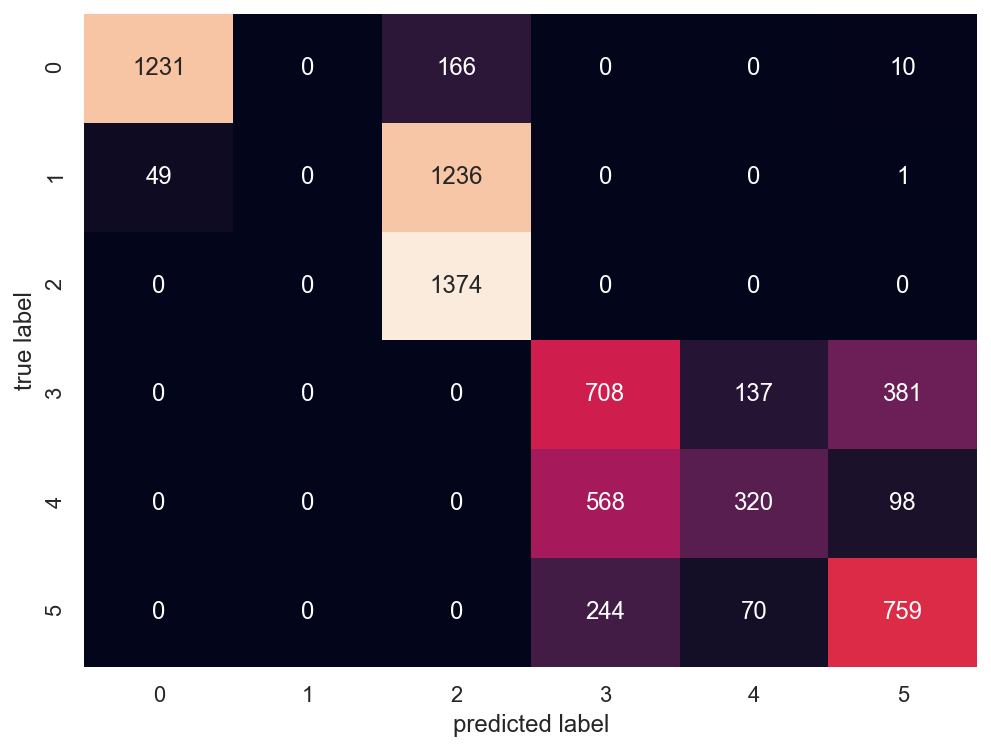

In [166]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_int, labels)
plt.figure(figsize=(8,6))
sns.heatmap(mat, annot=True, fmt='d', cbar=False)
plt.ylabel('true label')
plt.xlabel('predicted label');

## Нахождение оптимального количества кластеров

Теперь представим, что начальное распределение кластеров неизвестно (что чаще всего встречается на практике) и стоит задача каким-то образом определить оптимальное количество кластеров и произвести кластеризацию.

В этом случае, использя алгоритм K-Means, оптимальное колличество кластеров определяется по двум метриками:
- инерция (среднеквадратичное расстояние между каждым образцом и его ближайшим центроидом)
- silhouette_score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [152]:
inertia = []
silhouette = []
n_clusters = np.arange(2,10) # диапазон возможного количества кластеров

for n in n_clusters:
    kmeans = MiniBatchKMeans(n_clusters=n)
    labels = kmeans.fit_predict(x)
    inertia.append(kmeans.inertia_) # записываем значение инерции для каждого кол-ва кластеров
    silhouette.append(silhouette_score(x, labels)) # записываем значение силуэта для каждого кол-ва кластеров

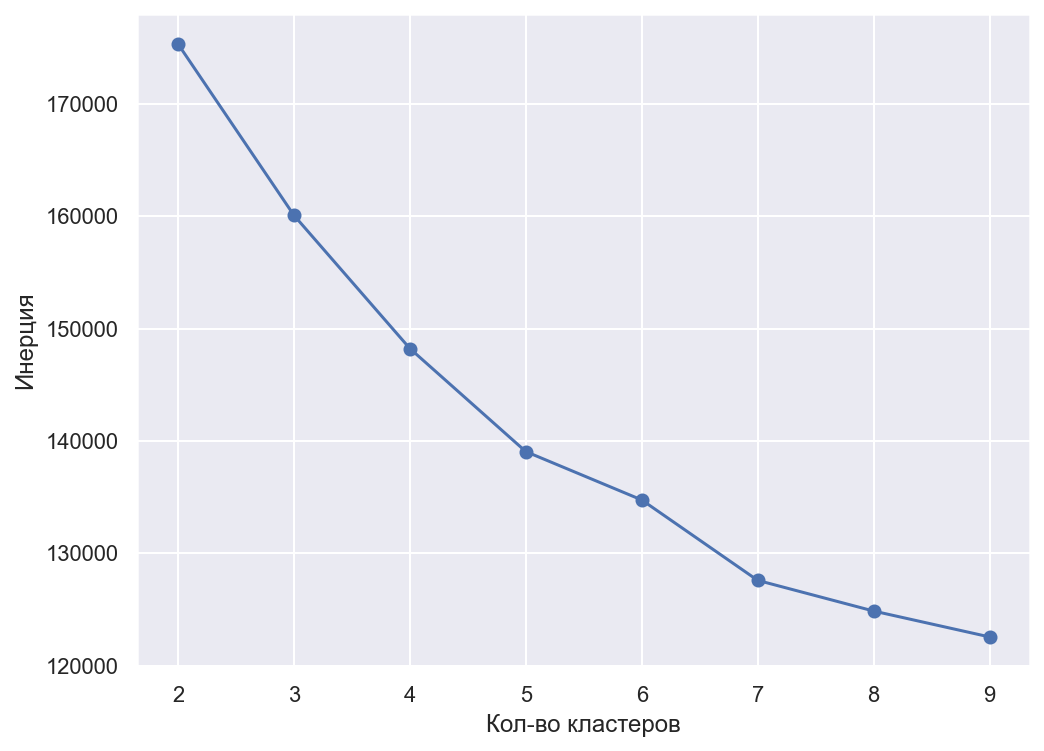

In [158]:
plt.figure(figsize=(8,6))
plt.plot(n_clusters, inertia, 'o-')
plt.xlabel('Кол-во кластеров')
plt.ylabel('Инерция');

График инерции как функции количества кластеров k, кривая часто содержит точку перегиба, так называемый "локоть", в котором изменяется скорость уменьшения инерции с ростом k. На приведенном выше графике видно, что инерция быстро падает при увеличение k до 5-6, а при дальнейшем росте уменьшается медленнее. Таким образом это первый показатель, что кол-во кластеров 5 или 6, явдяется неплохим выбором для данного датасета.

Более точный подход предусматривает использование оценки силуэта:

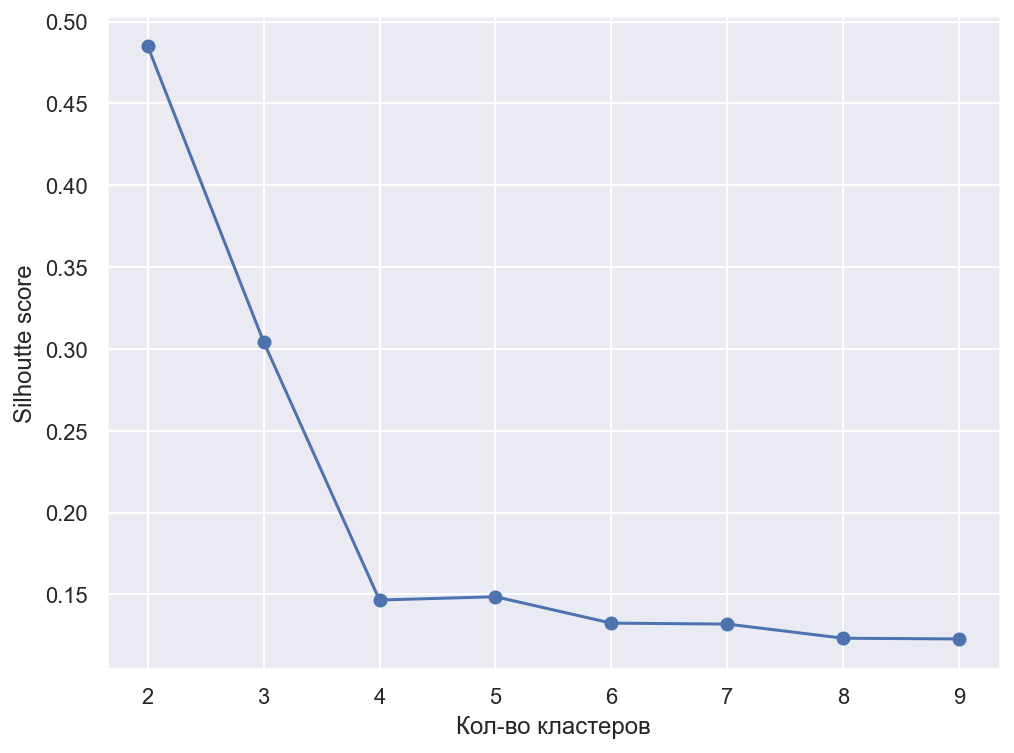

In [160]:
plt.figure(figsize=(8,6))
plt.plot(n_clusters, silhouette, 'o-')
plt.xlabel('Кол-во кластеров')
plt.ylabel('Silhoutte score');

Высокие значения silhoutte score показывают лучший выбор кол-ва кластеров. Однако, всегда стоит анализировать полученный результат. В данном случае, если бы мы просто использовали лучший silhoutte score, то оптимальным кол-вом кластеров было бы 2, однако, зная природу создания датасета, резонно предположить, что число различных активностей, которые человек совершает в течение дня, должно быть как минимум равно 4: сидеть, лежать, стоять, ходить. Поэтому, рассматривая кол-ва кластеров больше или равное 4, мы видим, что 5 кластеров является наиболее оптимальным вариантом:

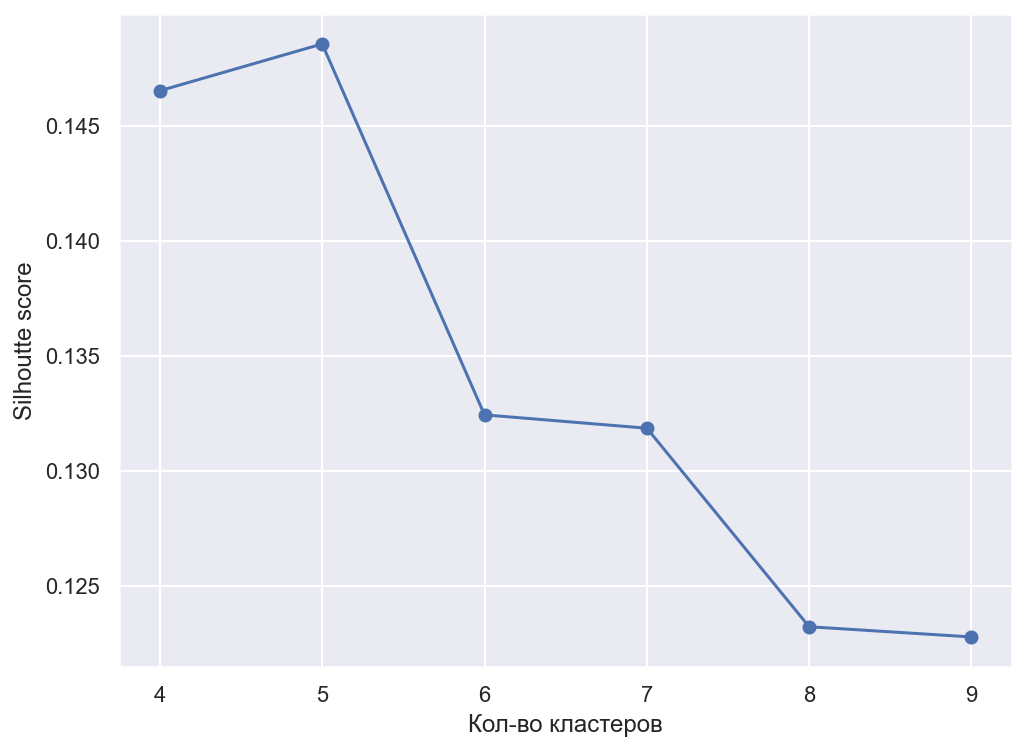

In [162]:
plt.figure(figsize=(8,6))
plt.plot(n_clusters[2:], silhouette[2:], 'o-')
plt.xlabel('Кол-во кластеров')
plt.ylabel('Silhoutte score');

В целом, как вы могли видеть, оценка кластеризации представляет из себя непростую задачу и для анализа оптимального варианта кластеризации нельзя просто доверяться метрикам, а нужно анализировать задачу целиком, возможно с привлечением целевых экспертов.